# 9. Base-station side: Downlink Data Communication in 5G Networks

In this project we will demonstrate the transmission and reception of the data from base-station (BS) using low cost SDRs. The whole simulation consists of two parts:

**Transmitter side**:

1. Generate the SSB block
2. Generate the transport block ==> Process it with PDSCH chain ==> Create the slot resource grids
3. Generate the resource grid and load SSB + PDSCH both into it.
4. Pass the resource grid through the OFDM modulator: Generate the time domain I/Q samples.
5. Pass it to the SDR and radiate the signal to the medium.

**Receiver side**:

1. Sample the medium to receive the samples and store thm in the buffer.
2. Downlink synchronization
    - This is performed using synchronization signal block (SSB).
    - Helps with 
        - time/frame synchronization.
        - Coarse CFO correction.
        - Cell ID detection.
        - Decoding MIB information.
3. Data transmission and decoding
    - 

![SSB Transmitter](images/Procedure.png)

## 9.1. Import Python Libraries

In [1]:
# %matplotlib widget

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation

import numpy as np
import adi

# from IPython.display import display, HTML
# display(HTML("<style>.container { width:98% !important; }</style>"))

## 9.1. 5G Toolkit Libraries

In [2]:
import sys
sys.path.append("../../../../")

from toolkit5G.SequenceGeneration import PSS, SSS, DMRS
from toolkit5G.PhysicalChannels   import PBCH
from toolkit5G.ResourceMapping    import SSB_Grid, ResourceMapperSSB
from toolkit5G.OFDM               import OFDMModulator
from toolkit5G.MIMOProcessing     import AnalogBeamforming
from toolkit5G.Configurations     import TimeFrequency5GParameters, GenerateValidSSBParameters

from toolkit5G.SequenceGeneration import PSS, SSS, DMRS
from toolkit5G.PhysicalChannels   import PBCH, PBCHDecoder
from toolkit5G.ResourceMapping    import SSB_Grid, ResourceMapperSSB
from toolkit5G.OFDM               import OFDMModulator, OFDMDemodulator
from toolkit5G.MIMOProcessing     import AnalogBeamforming, ReceiveCombining
from toolkit5G.ReceiverAlgorithms import PSSDetection, SSSDetection, ChannelEstimationAndEqualization, DMRSParameterDetection
from toolkit5G.Configurations     import TimeFrequency5GParameters, GenerateValidSSBParameters


from toolkit5G.PhysicalChannels.PDSCH import ComputeTransportBlockSize
from toolkit5G.PhysicalChannels       import PDSCHLowerPhy, PDSCHUpperPhy, PDSCHDecoderLowerPhy, PDSCHDecoderUpperPhy
from toolkit5G.Configurations         import PDSCHLowerPhyConfiguration, PDSCHUpperPhyConfiguration
from toolkit5G.SymbolMapping          import Mapper, Demapper
from toolkit5G.Scrambler              import DeScrambler, Scrambler
from toolkit5G.SymbolMapping          import Demapper
from toolkit5G.PhysicalChannels.PDSCH import LayerDemapper

from toolkit5G.PhysicalChannels   import PBCHDecoder
from toolkit5G.OFDM               import OFDMDemodulator
from toolkit5G.ReceiverAlgorithms import PSSDetection, SSSDetection, ChannelEstimationAndEqualizationPBCH, DMRSParameterDetection, CarrierFrequencyOffsetEstimation, ChannelEstimationAndEqualizationPDSCH

from toolkit5G.PhysicalChannels       import PDSCHLowerPhy, PDSCHUpperPhy, PDSCHDecoderLowerPhy, PDSCHDecoderUpperPhy


## 9.1. Emulation Parameters

In [3]:
# Carrier Frequency
carrierFrequency = 1*10**9
numBatches       = 9        # Number of batches considered for simulation
scs              = 15*10**3   # Subcarrier Spacing for simulation
numBSs           = 1          # Number of BSs considered for simulation
bandwidth        = 30*10**6

# Number of UEs considered for simulation
numUEs           = numBatches # For now we are assuming that the numbatches are captured via numUEs
numRB            = 170         # Number of Resource mapping considered for simulation | # 1 RB = 12 subcarrier
slotNumber       = 0 # Index of the slot considered for simulation
Nfft             = 2048       # FFTSize

Nt               = 1

print("************ Simulation Parameters *************")
print()
print("     numBatches: "+str(numBatches))
print("          numRB: "+str(numRB))
print("       fft Size: "+str(Nfft))
print("         numBSs: "+str(numBSs))
print("         numUEs: "+str(numUEs))
print("            scs: "+str(scs))
print("     slotNumber: "+str(slotNumber))
print("Num of Antennas: "+str(Nt))
print()
print("********************************************")

************ Simulation Parameters *************

     numBatches: 9
          numRB: 170
       fft Size: 2048
         numBSs: 1
         numUEs: 9
            scs: 15000
     slotNumber: 0
Num of Antennas: 1

********************************************


## 9.1. PDSCH Transmitter Implementation

![PDSCH Transmitter](images/PDSCH_Tx.png)

## 9.1. Generate the PDSCH related parameters: Use PDSCH Configurations

In [4]:
######################################### PDSCH Lower Physical Layer Parameters #########################################
pdschMappingType       = 'PDSCH-mapping-type-B'   # "PDSCH mapping type A" or "PDSCH mapping type B"
maxLength              = 'len1'                   #
startSymbol            = 2                        # 
numSymbols             = 12                       # 
betaDMRS               = 1                        # 0 to 1
configurationType      = "Configuration-type-1"   # "Configuration-type-1" or "Configuration-type-2"
dmrsTypeAPosition      = "pos2"                   # "pos2" or "pos3"
dmrsAdditionalPosition = 'pos1'                   # "pos0", "pos1", "pos2" or "pos3"
ld                     = numSymbols
l0                     = startSymbol
l1                     = 11
rank                   = 1
pdschLowerPhyConfig    = PDSCHLowerPhyConfiguration(pdschMappingType = pdschMappingType, maxLength = maxLength, 
                                                    betaDMRS = betaDMRS, configurationType = configurationType, 
                                                    dmrsTypeAPosition = dmrsTypeAPosition, rank = rank,
                                                    dmrsAdditionalPosition = dmrsAdditionalPosition, l0 = l0, 
                                                    l1 = l1, startSymbol = startSymbol, numSymbols= numSymbols, 
                                                    ld = ld, scramblingID = 0, nSCID = 0)
scramblingID           = pdschLowerPhyConfig.scramblingID
nSCID                  = pdschLowerPhyConfig.nSCID


######################################### PDSCH Upper Physical Layer Parameters #########################################

numTBs                 = 1
mcsIndex               = 15
mcsTable               = 'pdschTable1'
scalingField           = '00'
additionalOverhead     = 0
scalingField           = None
additionalOverhead     = None

pdschUpperPhyConfig    = PDSCHUpperPhyConfiguration(pdschMappingType = pdschMappingType, configurationType = configurationType, 
                                                    dmrsTypeAPosition = dmrsTypeAPosition, maxLength = maxLength, numTBs = numTBs,
                                                    mcsIndex = mcsIndex, dmrsAdditionalPosition = dmrsAdditionalPosition, l0 = l0, 
                                                    mcsTable = mcsTable, ld = ld, l1 = l1, startSymbol = startSymbol, numRB = numRB,
                                                    numSymbols = numSymbols, rank = rank, scalingField = scalingField, 
                                                    additionalOverhead = additionalOverhead)

numTBs                 = pdschUpperPhyConfig.numTBs
mcsIndex               = pdschUpperPhyConfig.mcsIndex
mcsTable               = pdschUpperPhyConfig.mcsTable

numlayers              = pdschUpperPhyConfig.numlayers
tbLen1                 = pdschUpperPhyConfig.tbLen1
codeRate               = pdschUpperPhyConfig.codeRate
modOrder               = pdschUpperPhyConfig.modOrder

scalingField           = pdschUpperPhyConfig.scalingField
additionalOverhead     = pdschUpperPhyConfig.additionalOverhead
dmrsREs                = 6
dmrsREs                = pdschUpperPhyConfig.dmrsREs
scalingField           = pdschUpperPhyConfig.scalingField


numTargetBits1         = pdschUpperPhyConfig.numTargetBits1
if(numTBs == 2):
    numTargetBits1     = pdschUpperPhyConfig.numTargetBits1
    numTargetBits2     = pdschUpperPhyConfig.numTargetBits2
    tbLen2             = pdschUpperPhyConfig.tbLen2

numTargetBits          = pdschUpperPhyConfig.numTargetBits

************ PDSCH Parameters *************

       pdschMappingType: PDSCH-mapping-type-B
            startSymbol: 2
             numSymbols: 12
               betaDMRS: 1
                   rank: 1
      configurationType: Configuration-type-1
              maxLength: len1
      dmrsTypeAPosition: pos2
 dmrsAdditionalPosition: pos1
           Duration, ld: 12
       Start symbol, l0: 2
     Start symbol-1, l1: 11
          num of Layers: 1

********************************************
********************************************
          tbsize-1: 54296

            numTBs: 1
            numCBs: 7
         numLayers: 1 | LayerperTB: [1 0]
             numRB: 170
          coderate: 0.6015625
          modOrder: 4
additionalOverhead: 0
numberTargetBits: 89760
********************************************


In [5]:
dmrsREs, scalingField, additionalOverhead

(12, '00', 0)

## 9.1. Generate the PDSCH Resource Grid


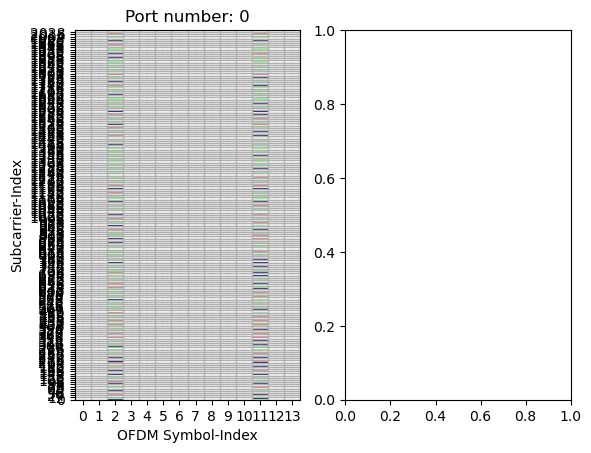

((<Figure size 640x480 with 2 Axes>,
  array([<Axes: title={'center': 'Port number: 0'}, xlabel='OFDM Symbol-Index', ylabel='Subcarrier-Index'>,
         <Axes: >], dtype=object)),
 None)

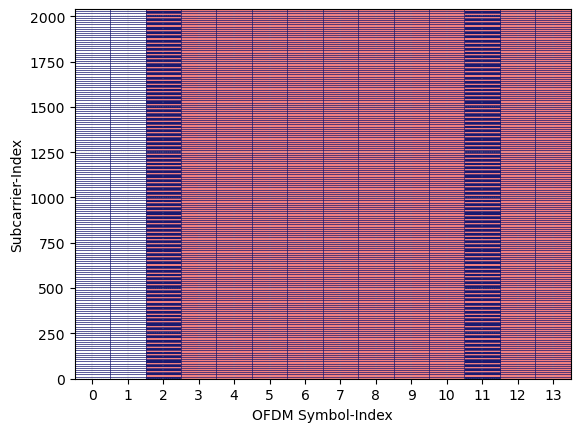

In [6]:

pdschUpperPhy = PDSCHUpperPhy(symbolsPerSlot = numSymbols, numRB = numRB, mcsIndex = mcsIndex, 
                              numlayers = numlayers, scalingField = scalingField, additionalOverhead = additionalOverhead,
                              dmrsREs = dmrsREs, numTBs=numTBs, pdschTable = mcsTable, verbose = False)

codeword      = pdschUpperPhy(tblock = [None, None], rvid = [0, 0], enableLBRM = [False, False], 
                              numBatch = numBatches, numBSs = numBSs)

rnti          = 0
nID           = 0
bits2         = codeword[1] if numTBs == 2 else None

pdschLowerPhyChain = PDSCHLowerPhy(pdschMappingType, configurationType, dmrsTypeAPosition, 
                                   maxLength, dmrsAdditionalPosition, l0, ld, l1)
resourceGrid  = pdschLowerPhyChain(codeword[0], numRB, rank, slotNumber, scramblingID,
                                   nSCID, rnti, nID, modOrder, startSymbol, bits2 = bits2)

## Load the resource Grid into the transmision Grid
txGrid        = np.zeros(resourceGrid.shape[0:-1]+(Nfft,), dtype= np.complex64)
bwpOffset     = np.int32(0.5*(Nfft-numRB*12))
txGrid[...,bwpOffset:bwpOffset+numRB*12] = np.sqrt(1/rank)*resourceGrid

txGrid        = txGrid/(np.linalg.norm(np.abs(txGrid), axis=-1)[...,np.newaxis] + 0.0001)

pdschLowerPhyChain.displayDMRSGrid(), pdschLowerPhyChain.displayResourceGrid()

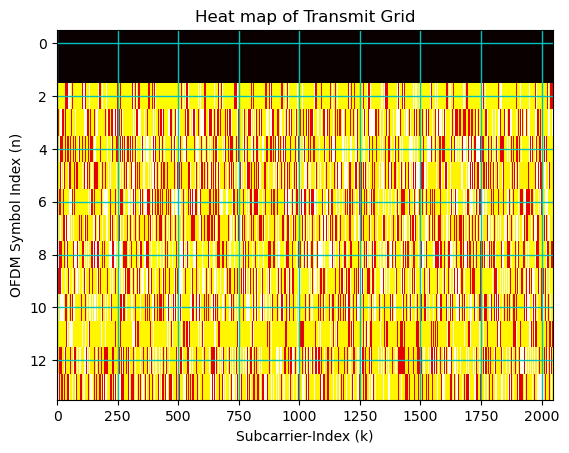

In [7]:
# Plot Resource Grid
#################################################################
fig, ax = plt.subplots()
plt.imshow(np.abs(txGrid[0,0,0]), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("OFDM Symbol Index (n)")
ax.set_title("Heat map of Transmit Grid")
# Gridlines based on minor ticks
plt.show()

## 9.1. SSB Transmitter Implementation

![SSB Transmitter](images/PBCH_SDR_Tx.svg)

## 9.1. Generate the SSB Resource Grid


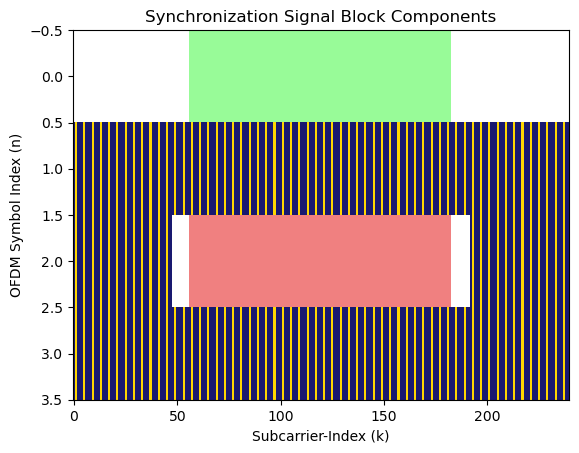

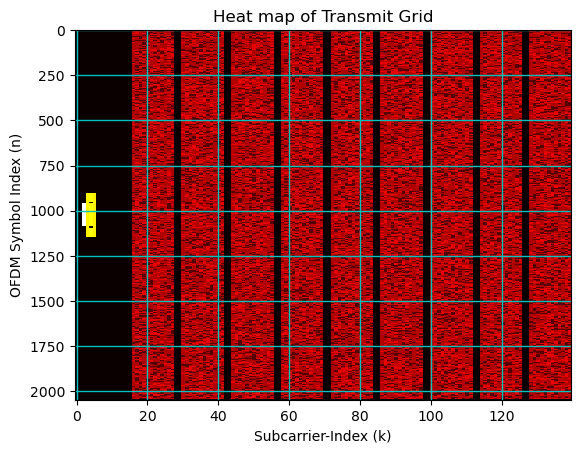

In [8]:
## This class fetches valid set of 5G parameters for the system configurations
nSymbolFrame   = 14
numOFDMSymbols = 14
tfParams    = TimeFrequency5GParameters(bandwidth, scs, fftsize=Nfft)
tfParams(nSymbolFrame, typeCP = "normal")
nRB         = tfParams.numRBs        # SSB Grid size (Number of RBs considered for SSB transition)
Neff        = nRB*12
lengthCP    = (tfParams.lengthCP).astype(np.int32)    # CP length
#___________________________________________________________________

#### Generate MIB Information
lamda                           = 3e8/carrierFrequency
nSCSOffset                      = 1
ssbParameters                   = GenerateValidSSBParameters(carrierFrequency, nSCSOffset, 
                                                             "caseA", ssbSubCarrierOffset = np.array([0]))

systemFrameNumber               = ssbParameters.systemFrameNumber
subCarrierSpacingCommon         = scs
ssbSubCarrierOffset             = ssbParameters.ssbSubCarrierOffset
DMRSTypeAPosition               = ssbParameters.DMRSTypeAPosition
controlResourceSet0             = ssbParameters.controlResourceSet0
searchSpace0                    = ssbParameters.searchSpace0

isPairedBand                    = ssbParameters.isPairedBand
nSCSOffset                      = ssbParameters.nSCSOffset
choiceBit                       = ssbParameters.choiceBit
ssbType                         = ssbParameters.ssbType
nssbCandidatesInHrf             = ssbParameters.nssbCandidatesInHrf
ssbIndex                        = ssbParameters.ssbIndex
hrfBit                          = ssbParameters.hrfBit
cellBarred                      = ssbParameters.cellBarred
intraFrequencyReselection       = ssbParameters.intraFrequencyReselection
withSharedSpectrumChannelAccess = ssbParameters.withSharedSpectrumChannelAccess

Nsc_ssb                         = 240
Nsymb_ssb                       = 4
#_______________________________________


N_ID2        = np.random.randint(3)

# Generate PSS sequence
pssObject    = PSS(N_ID2);
pssSequence  = pssObject()

N_ID1        = np.random.randint(336)
N_ID         = 3*N_ID1 + N_ID2

# Generate SSS sequence
sssObject    = SSS(N_ID1, N_ID2);
sssSequence  = sssObject()

# Generate DMRS sequence
dmrsLen      = 144;
dmrsObject   = DMRS("PBCH", N_ID, ssbIndex, nssbCandidatesInHrf, hrfBit)
# dmrsSeq = dmrs.getSequence("tensorflow")
dmrsSequence = dmrsObject(dmrsLen)


# Generate PBCH symbols
pbchObject   = PBCH(carrierFrequency, choiceBit, subCarrierSpacingCommon, DMRSTypeAPosition,
                   controlResourceSet0, searchSpace0, cellBarred, intraFrequencyReselection,
                   systemFrameNumber, ssbSubCarrierOffset, hrfBit, ssbIndex, N_ID,
                   nssbCandidatesInHrf)

pbchSymbols  = pbchObject()

## Generate SSB Object
ssbObject    = SSB_Grid(N_ID, True)
ssb          = ssbObject(pssSequence, sssSequence, dmrsSequence, pbchSymbols)  # generating SSB using PSS,SSS, PBCH payload and DMRS.   

## Loading SSB to Resource Grid
ssbPositionInBurst    = np.zeros(nssbCandidatesInHrf, dtype=int)
ssbPositionInBurst[0] = 1 

ssbRGobject    = ResourceMapperSSB(ssbType, carrierFrequency, isPairedBand, withSharedSpectrumChannelAccess)

offsetInRBs    = int((nRB-20)/2)
ssbGrid        = ssbRGobject(ssb[0], ssbPositionInBurst, offsetInSubcarriers = ssbSubCarrierOffset,
                      offsetInRBs = offsetInRBs, numRBs = nRB)[0:14]         # SSB Grid of size 14 X numbers of RBs x 12.
fig, ax = ssbObject.displayGrid(option=1)


firstSymbolIndex   = int(2)
numofGuardCarriers = (int((Nfft - Neff)/2), int((Nfft - Neff)/2))
offsetToPointA     = 0
firstSCIndex       = int(numofGuardCarriers[0] + offsetToPointA)

ssbResGrid = np.zeros((numOFDMSymbols, Nfft), dtype= np.complex64)
ssbResGrid[:, firstSCIndex:firstSCIndex+ssbGrid.shape[-1]] = ssbGrid

#__________________________________________________

## Concatenate the SSB and PDSCH Grid
X                 = np.concatenate([ssbResGrid, txGrid[:,0,0].reshape(-1,txGrid.shape[-1])], axis=0)

## OFDM Modulation at Transmitter
#####################################
modulator = OFDMModulator(lengthCP[1])
x_time    = modulator(X).flatten()
#______________________________________________________

# Plot Resource Grid
#################################################################
fig, ax = plt.subplots()
plt.imshow(np.abs(X).T, cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("OFDM Symbol Index (n)")
ax.set_title("Heat map of Transmit Grid")
# Gridlines based on minor ticks
plt.show()

## 9.1. SDR-Setup Configurations

In [9]:
## SDR Parameters
sample_rate         = Nfft*scs

# Pulse Shaping
numSamplesPerSymbol = 1

# number of samples returned per call to rx()
buffer_size         = int(Nfft*1.2*numSamplesPerSymbol*112) 

# Basic SDR Setup
sdr = adi.Pluto("ip:192.168.3.1")
sdr.sample_rate           = int(sample_rate)

# Config Tx
sdr.tx_rf_bandwidth       = int(60*10**6) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo                 = int(carrierFrequency)
sdr.tx_hardwaregain_chan0 = 0 # Increase to increase tx power, valid range is -90 to 0 dB


## 9.1. Transmission: SDR RF Transmitter

In [10]:

# Start the transmitter
sdr.tx_cyclic_buffer = True  # Enable cyclic buffers
scalingFactor = 1.1*2**17
pulseShaping  = 1
sdr.tx(scalingFactor*x_time) # start transmitting


In [11]:
np.abs(scalingFactor*x_time).max(), np.abs(scalingFactor*x_time).min()

(11471.27841685508, 0.0)

In [12]:
N_ID

557